In [1]:
import numpy as np

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

from gradvi.tests import toy_priors, toy_data
from gradvi.models import basis_matrix as gvbm
from gradvi.optimize import moving_average as gvma
from gradvi.inference import Trendfiltering
from gradvi.models import TrendfilteringModel

from mrashpen.utils import R_trendfilter
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models.mixture_gaussian import emfit

In [2]:
n = 512
x = np.linspace(0, 1, n)
np.random.seed(100)

degree = 1
nknots = 4
strue  = 0.2
knots  = np.linspace(0, 1, nknots+2)[1:-1]

data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "normal", seed = 100,
                        include_intercept = False)

In [3]:
s2_true = np.var(data.y - data.ytrue)

H = gvbm.trendfiltering(n, degree)
Hinv = gvbm.trendfiltering_inverse(n, degree)
prior = toy_priors.get_ash(k = 20, sparsity = 0.9, skbase = 2.0, skfactor = 1.0)
wtrue = emfit(np.dot(Hinv, data.ytrue), prior.sk)
prior.update_w(wtrue)

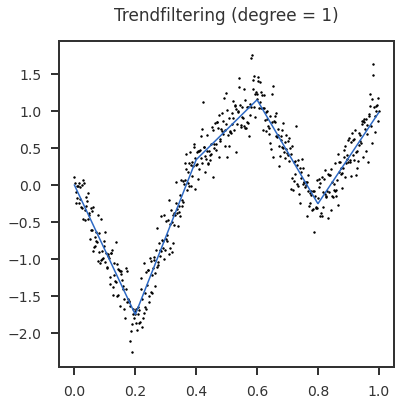

In [4]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)
fig = plt.figure(figsize = (6, 6))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(data.x, data.y, s = 2, color = 'black')
ax.plot(data.x, data.ytrue)
ax.set_title(f"Trendfiltering (degree = {degree})", pad = 20)

plt.show()

In [5]:
'''
Get oracle ELBO from mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(H, data.y, prior.sk,
            binit = np.dot(Hinv, data.ytrue), winit = wtrue, s2init = s2_true,
            update_pi = False, update_sigma2 = False)

mrash_ypred = np.dot(H, mrash_r.coef) + mrash_r.intercept
oracle_elbo = mrash_r.elbo_path[-1]

Mr.ASH terminated at iteration 492.


In [6]:
tf_y, tf_fit = R_trendfilter.fit(data.y, order = degree)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [7]:
gv1 = Trendfiltering(maxiter = 20000, standardize_basis = False, standardize = False,
                     optimize_s = False, optimize_w = False)
gv1.fit(data.y, degree, prior, y_init = tf_y, s2_init = s2_true)

In [23]:
gv2 = Trendfiltering(maxiter = 1000, standardize_basis = False, standardize = False,
                     optimize_s = False, optimize_w = False,
                     method = 'cg', hessian_callable = None)
gv2.fit(data.y, degree, prior, y_init = tf_y, s2_init = s2_true)

In [9]:
def hessian_func(params):
    tfm = TrendfilteringModel(H, data.y, params, s2_true, prior, objtype = 'reparametrize', 
                             tf_degree = degree, tfbasis_matrix = H, 
                             tfbasis_scale_factors = (None, None), 
                             standardize_basis = False,
                             scale_basis = False)
    
    nm = tfm.get_normal_means_model()
    Mb, Mb_bgrad, Mb_wgrad, Mb_sj2grad, Mb_bgrad2 = nm.shrinkage_operator(jac = True, hess = True)
    lj, l_bgrad,  l_wgrad,  l_sj2grad, l_bgrad2  = nm.penalty_operator(jac = True, hess = True)

    r    = tfm._y - tfm.Xdotv(Mb)
    rTX  = tfm.XTdotv(r)

    hess = np.dot(tfm._X.T, tfm._X) * np.outer(Mb_bgrad, Mb_bgrad) / tfm._s2
    hess[np.diag_indices_from(hess)] += l_bgrad2 - (rTX * Mb_bgrad2 / tfm._s2)
    return hess

In [20]:
gv3 = Trendfiltering(maxiter = 1000, standardize_basis = False, standardize = False,
                     optimize_s = False, optimize_w = False,
                     method = 'newton-cg', hessian_callable = hessian_func, options = {'xtol': 1e-9})
gv3.fit(data.y, degree, prior, y_init = tf_y, s2_init = s2_true)

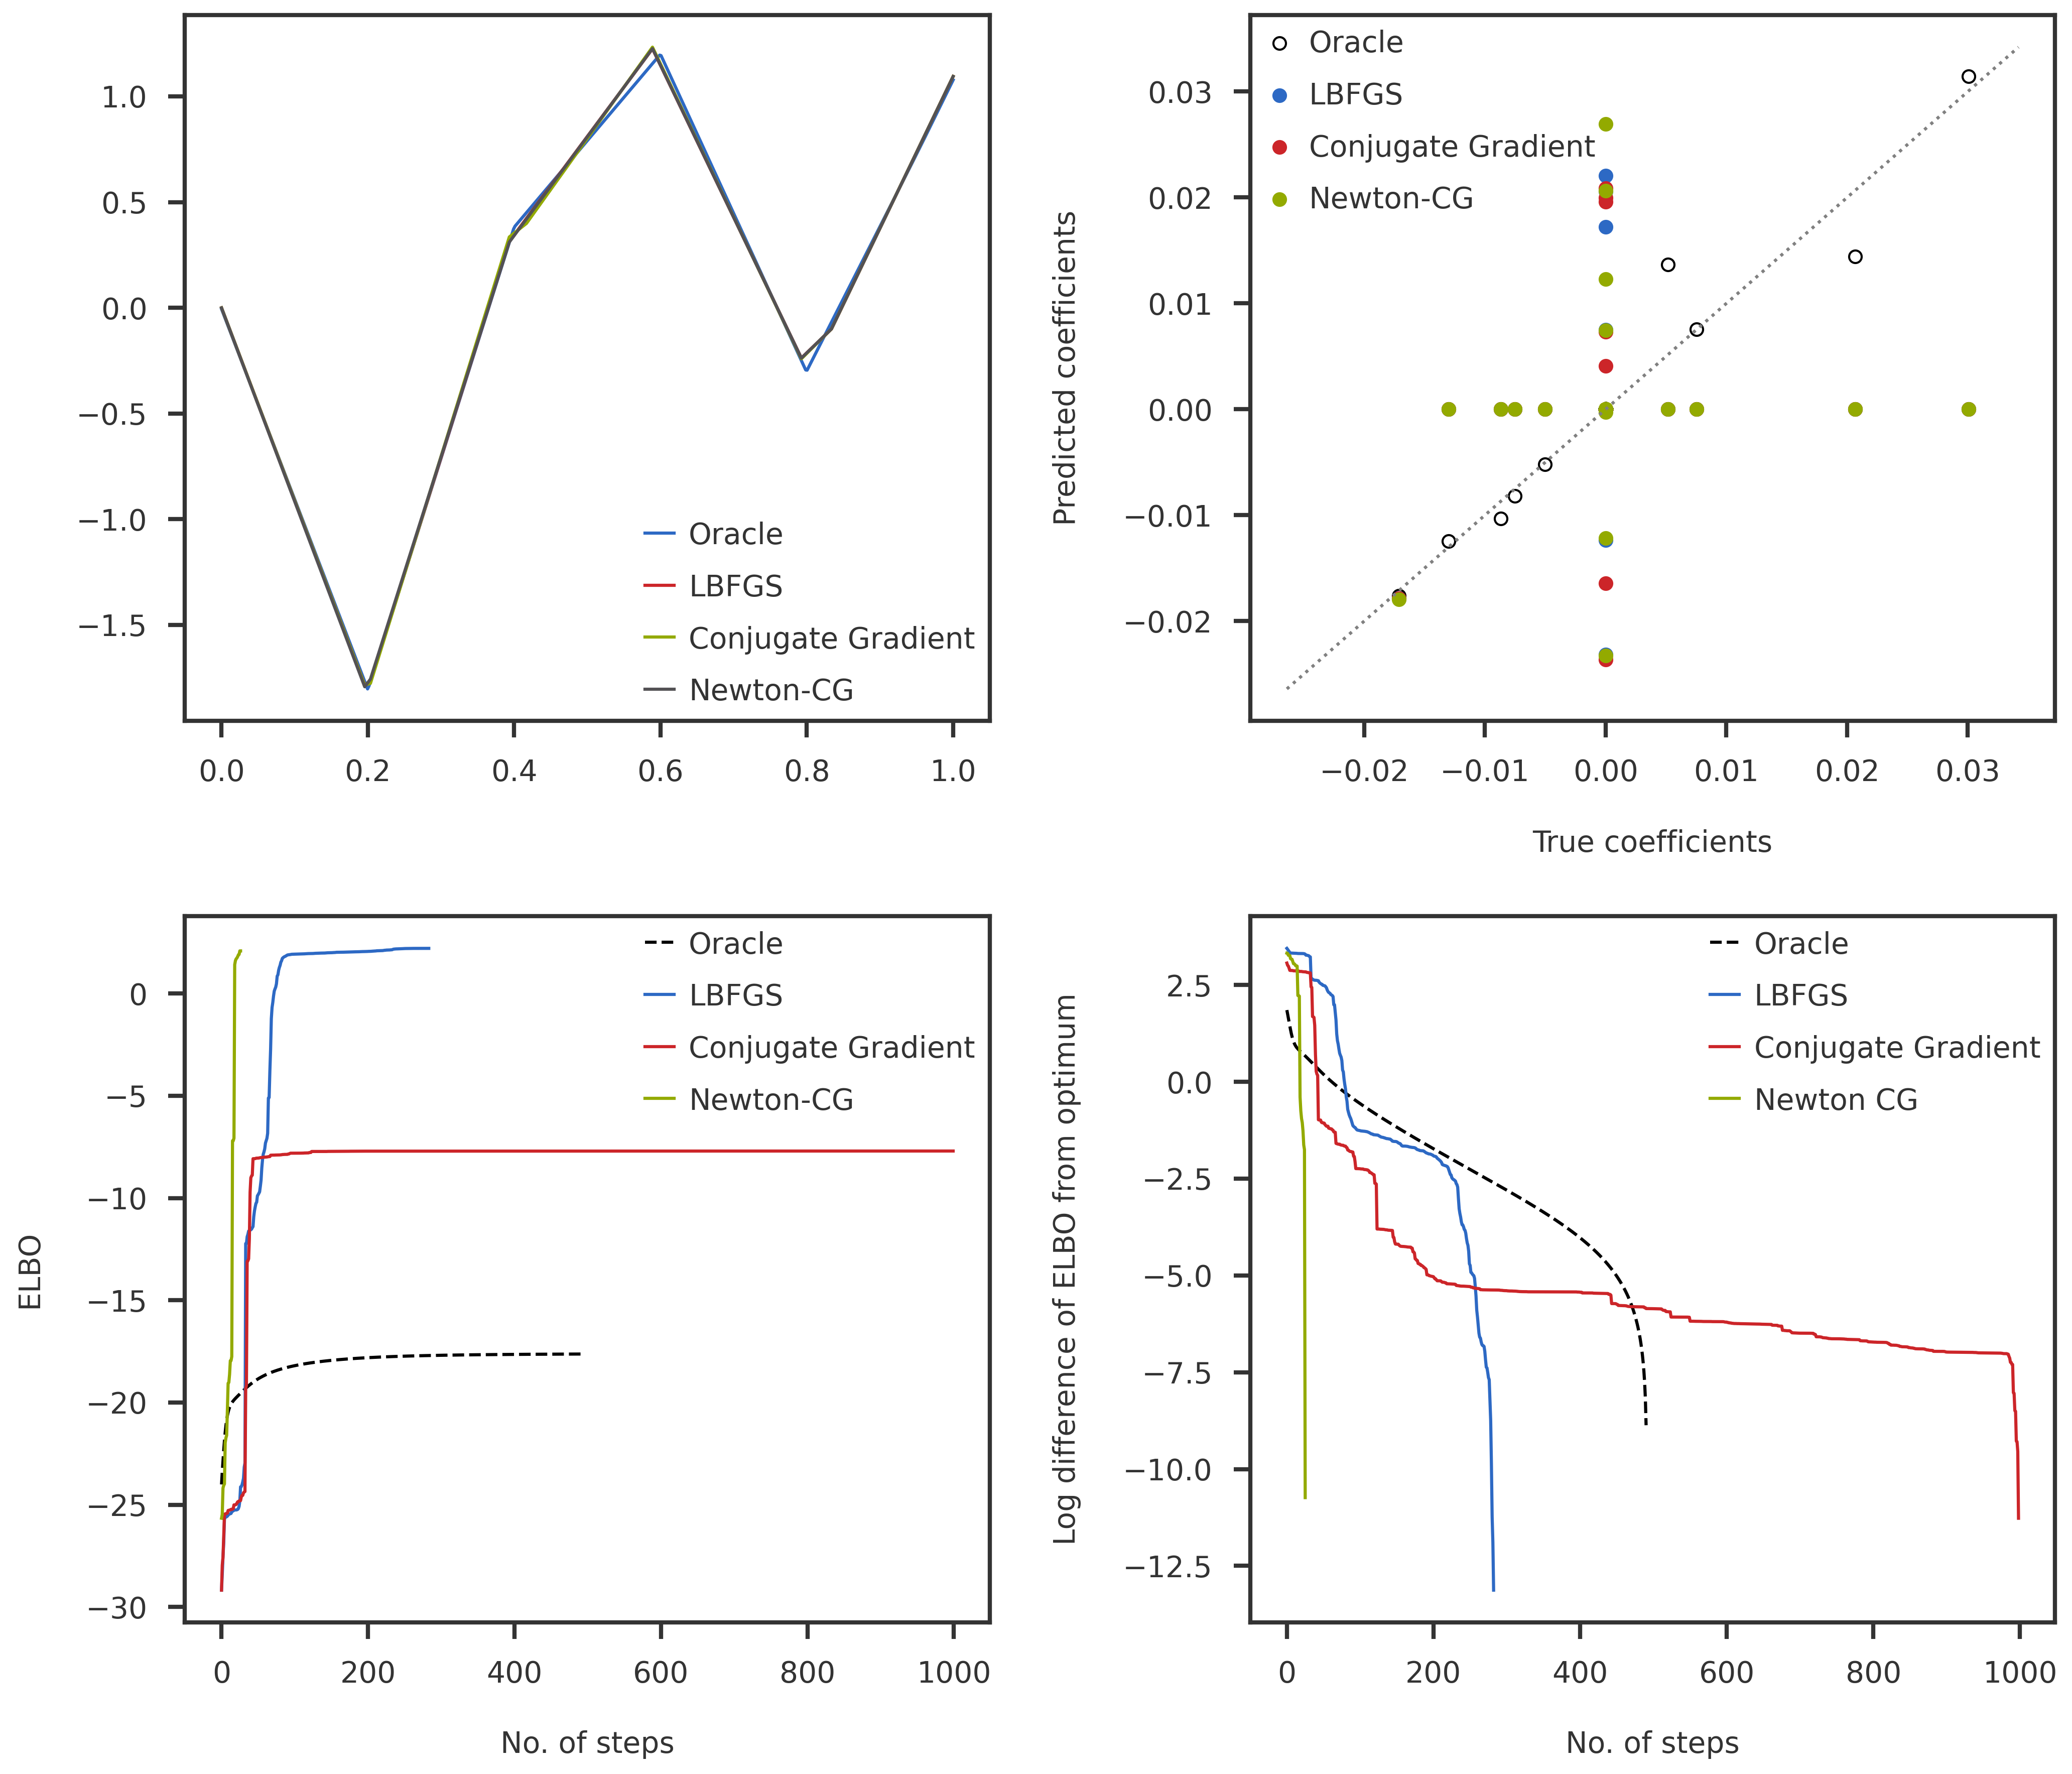

In [25]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)
fig = plt.figure(figsize = (14, 12))
ax  = [fig.add_subplot(2,2,i+1) for i in range(4)]

#ax[0].plot(data.x, data.ytrue, color = 'black', label = 'True')
ax[0].plot(data.x, mrash_ypred, label = 'Oracle')
ax[0].plot(data.x, gv1.ypred, label = 'LBFGS')
ax[0].plot(data.x, gv2.ypred, label = 'Conjugate Gradient')
ax[0].plot(data.x, gv3.ypred, label = 'Newton-CG')
ax[0].legend()

btrue = np.dot(Hinv, data.ytrue)
ax[1].scatter(btrue, mrash_r.coef, label = 'Oracle', color = 'black', facecolor = 'white')
ax[1].scatter(btrue, gv1.coef, label = 'LBFGS')
ax[1].scatter(btrue, gv2.coef, label = 'Conjugate Gradient')
ax[1].scatter(btrue, gv3.coef, label = 'Newton-CG')
ax[1].legend()
ax[1].set_xlabel("True coefficients")
ax[1].set_ylabel("Predicted coefficients")
mpl_utils.plot_diag(ax[1])

if mrash_r.niter > 0.2 * gv1.niter:
    ax[2].plot(np.arange(mrash_r.niter), - mrash_r.elbo_path, 
           color = 'black', ls = 'dashed', label = 'Oracle')
else:
    ax[2].axhline(y = - mrash_r.elbo_path[-1], color = 'black', ls = 'dashed', label = 'Oracle')
ax[2].plot(np.arange(gv1.niter), - gv1.elbo_path, label = 'LBFGS')
ax[2].plot(np.arange(gv2.niter), - gv2.elbo_path, label = 'Conjugate Gradient')
ax[2].plot(np.arange(gv3.niter), - gv3.elbo_path, label = 'Newton-CG')
ax[2].set_xlabel("No. of steps")
ax[2].set_ylabel("ELBO")
ax[2].legend()


ax[3].plot(np.arange(mrash_r.niter - 1), 
           np.log(mrash_r.elbo_path[:-1] - mrash_r.obj_path[-1]), 
           label = 'Oracle', color = 'black', ls = 'dashed')
ax[3].plot(np.arange(gv1.niter - 1), np.log(gv1.obj_path[:-1] - gv1.obj_path[-1]), label = 'LBFGS')
ax[3].plot(np.arange(gv2.niter - 1), np.log(gv2.obj_path[:-1] - gv2.obj_path[-1]), label = 'Conjugate Gradient')
ax[3].plot(np.arange(gv3.niter - 1), np.log(gv3.obj_path[:-1] - gv3.obj_path[-1]), label = 'Newton CG')
ax[3].legend()
ax[3].set_ylabel("Log difference of ELBO from optimum")
ax[3].set_xlabel("No. of steps")


fig.tight_layout(w_pad = 2.0, h_pad = 2.0)
plt.show()